Load patient diagnosis data from CSV and create a dictionary mapping Patient ID to Diagnosis.

In [1]:
import pandas as pd

csv_path =r"C:\Users\VIJAY SHARON L\Downloads\archive (8)\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv"
# Load CSV
df = pd.read_csv(csv_path, header=None, names=["Patient_ID", "Diagnosis"])

patient_labels = dict(zip(df["Patient_ID"].astype(str), df["Diagnosis"]))

print(list(patient_labels.items())[:10])


[('101', 'URTI'), ('102', 'Healthy'), ('103', 'Asthma'), ('104', 'COPD'), ('105', 'URTI'), ('106', 'COPD'), ('107', 'COPD'), ('108', 'LRTI'), ('109', 'COPD'), ('110', 'COPD')]


Segment and save labeled audio

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.io.wavfile import write


audio_folder = r"C:\Users\VIJAY SHARON L\Downloads\archive (8)\Respiratory_Sound_Database\Respiratory_Sound_Database\audio_and_txt_files"
output_folder = "segmented_audio"
os.makedirs(output_folder, exist_ok=True)


def extract_segments(audio_folder, output_folder, patient_labels):
    for file in os.listdir(audio_folder):
        if file.endswith(".wav"):
            audio_path = os.path.join(audio_folder, file)
            txt_path = os.path.join(audio_folder, file.replace(".wav", ".txt"))

            patient_id = file.split("_")[0]
            
            label = patient_labels.get(patient_id, "Unknown")  
            
            y, sr = librosa.load(audio_path, sr=None)

            if os.path.exists(txt_path):
                df = pd.read_csv(txt_path, sep="\t", header=None, names=["Start", "End", "Wheeze", "Crackle"])

                for index, row in df.iterrows():
                    start_time, end_time = row["Start"], row["End"]
                    start_sample = int(start_time * sr)
                    end_sample = int(end_time * sr)
                    segment = y[start_sample:end_sample]
                    segment_filename = f"{patient_id}_seg_{index}_{label}.wav"
                    write(os.path.join(output_folder, segment_filename), sr, segment)

    print("Segmentation complete. Files saved to:", output_folder)


extract_segments(audio_folder, output_folder, patient_labels)

C:\Users\VIJAY SHARON L\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Segmentation complete. Files saved to: segmented_audio


Convert audio to Mel images

In [3]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os


mel_spectrogram_folder = "mel_spectrograms"
os.makedirs(mel_spectrogram_folder, exist_ok=True)

# Function to convert wav files to Mel spectrograms
def convert_to_mel_spectrogram(audio_folder, output_folder):
    for file in os.listdir(audio_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(audio_folder, file)

            y, sr = librosa.load(file_path, sr=None)

            # Convert to Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            plt.figure(figsize=(4, 4))
            librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, fmax=8000, cmap='viridis')
            plt.axis("off")  
            output_image_path = os.path.join(output_folder, file.replace(".wav", ".png"))
            plt.savefig(output_image_path, bbox_inches="tight", pad_inches=0)
            plt.close()

    print("Mel spectrogram conversion complete. Images saved to:", output_folder)


convert_to_mel_spectrogram(output_folder, mel_spectrogram_folder)

C:\Users\VIJAY SHARON L\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Mel spectrogram conversion complete. Images saved to: mel_spectrograms


Organize and split dataset

In [4]:
import os
import shutil
import pandas as pd


mel_spectrogram_folder = "mel_spectrograms"
csv_path = r"C:\Users\VIJAY SHARON L\Downloads\archive (8)\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv"

output_dataset_folder = "dataset"


os.makedirs(output_dataset_folder, exist_ok=True)
copd_folder = os.path.join(output_dataset_folder, "COPD")
non_copd_folder = os.path.join(output_dataset_folder, "Non-COPD")
os.makedirs(copd_folder, exist_ok=True)
os.makedirs(non_copd_folder, exist_ok=True)


df = pd.read_csv(csv_path, header=None)
df.columns = ["patient_id", "condition"]
df["patient_id"] = df["patient_id"].astype(str)

# Move images to COPD / Non-COPD folders
for file in os.listdir(mel_spectrogram_folder):
    if file.endswith(".png"):
        patient_id = file.split("_")[0]  # Extract patient ID from filename
        condition = df[df["patient_id"] == patient_id]["condition"].values
        
        if len(condition) > 0:
            if condition[0] == "COPD":
                shutil.move(os.path.join(mel_spectrogram_folder, file), os.path.join(copd_folder, file))
            else:
                shutil.move(os.path.join(mel_spectrogram_folder, file), os.path.join(non_copd_folder, file))

print("Dataset organized into COPD and Non-COPD folders.")


Dataset organized into COPD and Non-COPD folders.


In [5]:
from sklearn.model_selection import train_test_split


def split_dataset(input_folder, output_train_folder, output_test_folder, test_size=0.2):
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    for category in ["COPD", "Non-COPD"]:
        category_folder = os.path.join(input_folder, category)
        images = os.listdir(category_folder)

        # Split into train and test
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        os.makedirs(os.path.join(output_train_folder, category), exist_ok=True)
        os.makedirs(os.path.join(output_test_folder, category), exist_ok=True)
        for img in train_images:
            shutil.move(os.path.join(category_folder, img), os.path.join(output_train_folder, category, img))
        for img in test_images:
            shutil.move(os.path.join(category_folder, img), os.path.join(output_test_folder, category, img))


train_folder = "train"
test_folder = "test"


split_dataset(output_dataset_folder, train_folder, test_folder)

print("Train-Test split complete.")

Train-Test split complete.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch_optimizer as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Define CNN model with ECA blocks and dual-path convolutions

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Efficient Channel Attention (ECA) Block
class ECALayer(nn.Module):
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)                      
        y = y.squeeze(-1).transpose(-1, -2)       
        y = self.conv(y)                         
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)  
        return x * y.expand_as(x)


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Dual-path convolution block
        self.conv1a = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.eca1 = ECALayer(32)

        # Conv block 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.eca2 = ECALayer(64)

        # Conv block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.eca3 = ECALayer(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x1 = F.relu(self.conv1a(x))
        x2 = F.relu(self.conv1b(x))
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.bn1(x))
        x = self.eca1(x)
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.eca2(x)
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.eca3(x)
        x = self.pool(x)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [8]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Lookahead(optim.RAdam(model.parameters(), lr=0.0001))

transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = datasets.ImageFolder(root='train', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training loop with dynamic sample weights and early stopping

In [9]:
def calculate_metrics(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss, all_labels, all_preds

# Training Loop with Dynamic Loss Scaling and Early Stopping

num_epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
best_loss = float('inf')
patience = 10
counter = 0

criterion_none = torch.nn.CrossEntropyLoss(reduction='none')  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        # Get per-sample losses (batch_size,)
        per_sample_losses = criterion_none(outputs, labels)

        # Add small epsilon to avoid division by zero
        weights = per_sample_losses / (per_sample_losses.sum() + 1e-8)

        # Weighted scalar loss
        weighted_loss = torch.sum(weights * per_sample_losses)

        weighted_loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += weighted_loss.item()

    train_acc, train_loss, _, _ = calculate_metrics(model, train_loader, device)
    test_acc, test_loss, _, _ = calculate_metrics(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

    # Early Stopping Check
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/100, Train Loss: 0.6919, Test Loss: 0.6918, Train Acc: 69.82%, Test Acc: 73.59%
Epoch 2/100, Train Loss: 0.6753, Test Loss: 0.6746, Train Acc: 75.21%, Test Acc: 75.37%
Epoch 3/100, Train Loss: 0.6346, Test Loss: 0.6334, Train Acc: 76.51%, Test Acc: 79.82%
Epoch 4/100, Train Loss: 0.5789, Test Loss: 0.5715, Train Acc: 82.17%, Test Acc: 86.65%
Epoch 5/100, Train Loss: 0.5376, Test Loss: 0.5308, Train Acc: 76.14%, Test Acc: 81.31%
Epoch 6/100, Train Loss: 0.5045, Test Loss: 0.4908, Train Acc: 88.21%, Test Acc: 91.69%
Epoch 7/100, Train Loss: 0.5016, Test Loss: 0.4875, Train Acc: 85.98%, Test Acc: 89.61%
Epoch 8/100, Train Loss: 0.4662, Test Loss: 0.4482, Train Acc: 89.97%, Test Acc: 93.47%
Epoch 9/100, Train Loss: 0.4702, Test Loss: 0.4586, Train Acc: 88.58%, Test Acc: 91.69%
Epoch 10/100, Train Loss: 0.4674, Test Loss: 0.4491, Train Acc: 88.58%, Test Acc: 91.10%
Epoch 11/100, Train Loss: 0.4644, Test Loss: 0.4486, Train Acc: 88.12%, Test Acc: 90.21%
Epoch 12/100, Train Loss: 0.44

Model performance plots

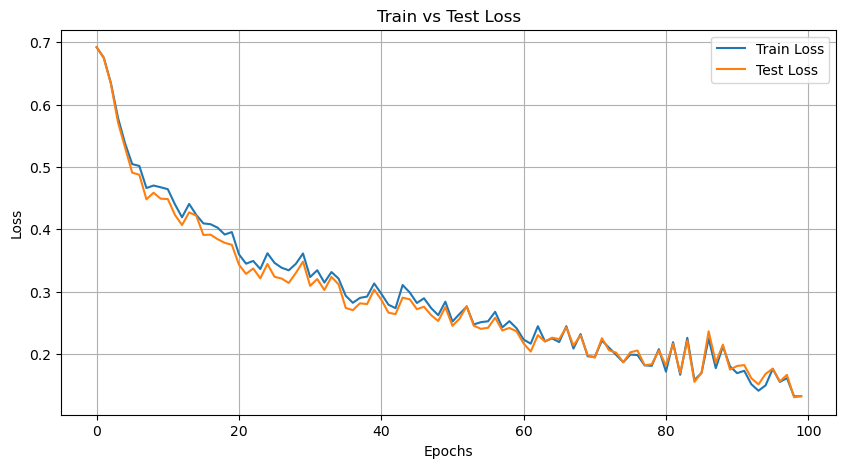

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()


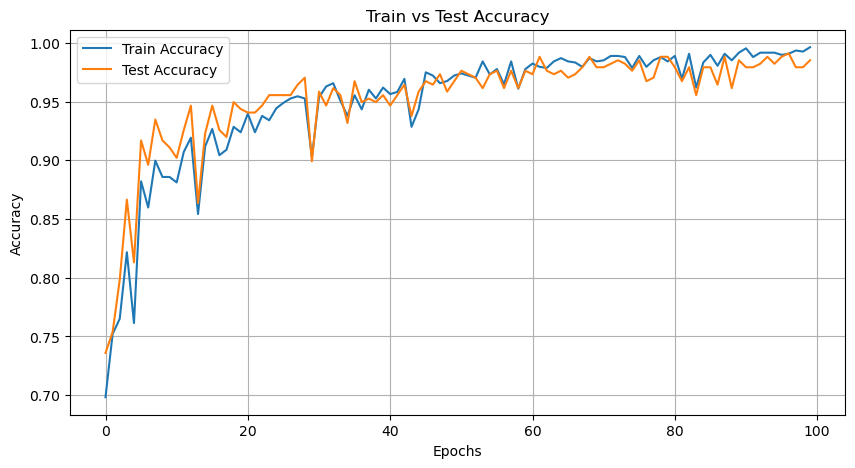

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


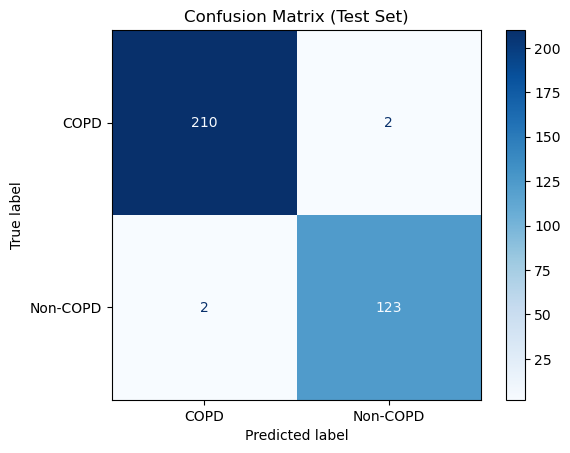

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


_, _, labels, preds = calculate_metrics(model, test_loader, device)
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["COPD", "Non-COPD"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [19]:
_, _, test_labels, test_preds = calculate_metrics(model, test_loader, device)

print("\nClassification Report:\n", classification_report(test_labels, test_preds, target_names=test_dataset.classes))


Classification Report:
               precision    recall  f1-score   support

        COPD       0.99      0.99      0.99       212
    Non-COPD       0.98      0.98      0.98       125

    accuracy                           0.99       337
   macro avg       0.98      0.98      0.98       337
weighted avg       0.99      0.99      0.99       337



C:\Users\VIJAY SHARON L\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


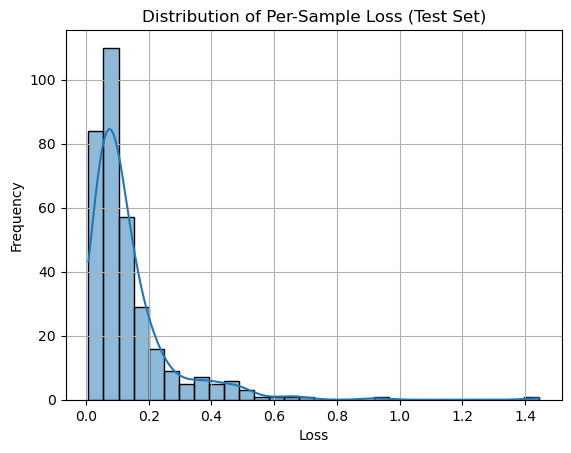

In [14]:
import seaborn as sns
import torch.nn.functional as F

model.eval()
all_losses = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        losses = criterion_none(outputs, labels)
        all_losses.extend(losses.cpu().numpy())

sns.histplot(all_losses, bins=30, kde=True)
plt.title("Distribution of Per-Sample Loss (Test Set)")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


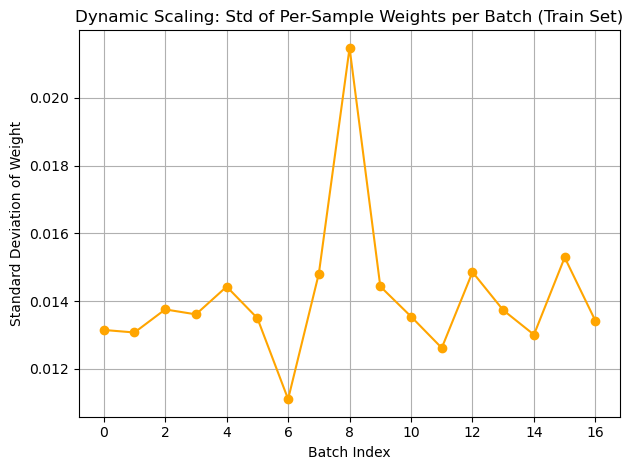

In [27]:
import matplotlib.pyplot as plt
import torch

model.eval()
weight_stds = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        per_sample_losses = criterion_none(outputs, labels)
        weights = per_sample_losses / (per_sample_losses.sum() + 1e-8)

        weight_stds.append(weights.std().item())  


plt.plot(weight_stds, marker='o', linestyle='-', color='orange')
plt.title("Dynamic Scaling: Std of Per-Sample Weights per Batch (Train Set)")
plt.xlabel("Batch Index")
plt.ylabel("Standard Deviation of Weight")
plt.grid(True)
plt.tight_layout()
plt.show()


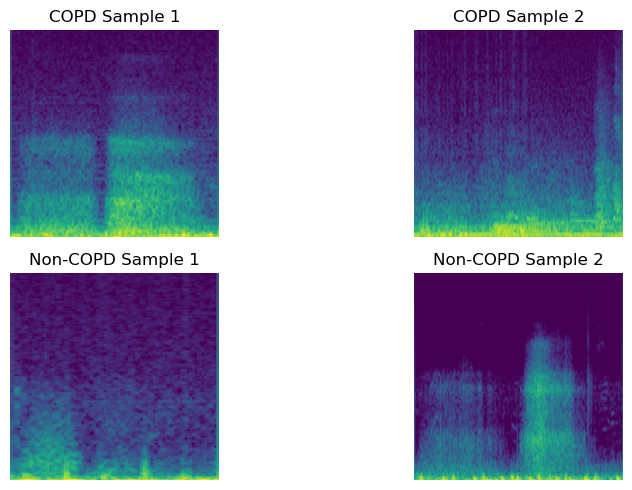

In [33]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def visualize_samples(dataset_folder, categories=["COPD", "Non-COPD"], samples_per_class=2):
    plt.figure(figsize=(10, 5))

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_folder, category)
        images = os.listdir(category_path)
        sample_images = random.sample(images, samples_per_class)

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(category_path, img_name)
            img = mpimg.imread(img_path)

            plt_idx = i * samples_per_class + j + 1
            plt.subplot(len(categories), samples_per_class, plt_idx)
            plt.imshow(img)
            plt.title(f"{category} Sample {j+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

train_folder = "test"  
visualize_samples(train_folder)


GRAD - CAM Visualization

C:\Users\VIJAY SHARON L\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


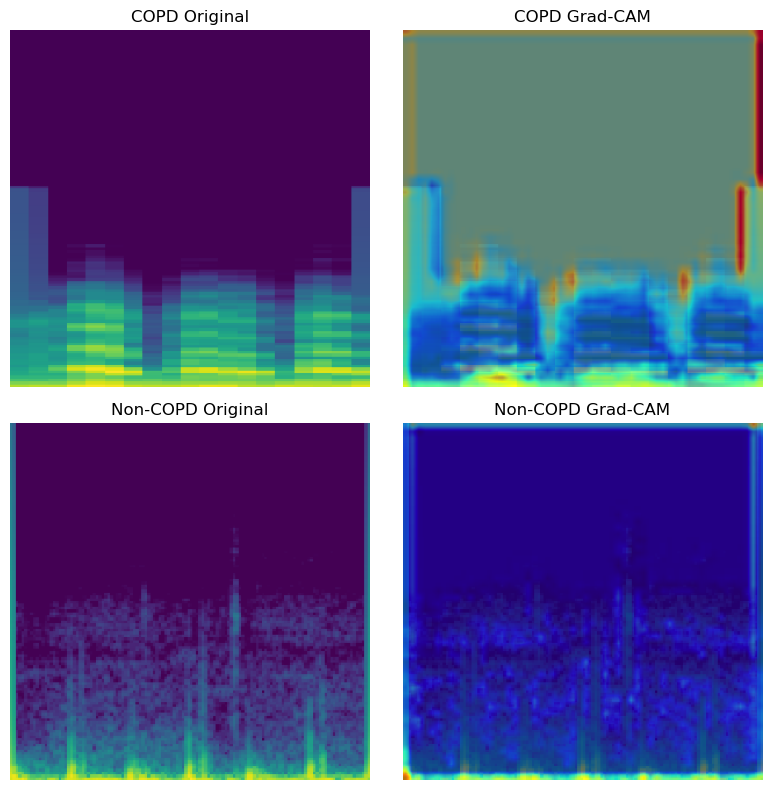

In [52]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
state_dict = torch.load('model.pth', map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()

# GradCAM 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        target = output[0, class_idx]
        target.backward()

        weights = self.gradients.mean(dim=[2,3], keepdim=True)  # Global avg pool on gradients
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = torch.relu(grad_cam_map)

        grad_cam_map = grad_cam_map.squeeze()
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map.cpu().numpy()

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def apply_heatmap_on_image(img_pil, heatmap):
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img_pil.size, resample=Image.BILINEAR)
    heatmap = np.array(heatmap)
    import cv2
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = np.array(img_pil) * 0.5 + heatmap * 0.5
    superimposed_img = np.clip(superimposed_img / superimposed_img.max(), 0, 1)

    return superimposed_img


test_folder = "test"
categories = ["COPD", "Non-COPD"]

fig, axes = plt.subplots(len(categories), 2, figsize=(8, len(categories) * 4))

for i, category in enumerate(categories):
    category_folder = os.path.join(test_folder, category)
    image_files = os.listdir(category_folder)
    image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    img_path = os.path.join(category_folder, image_files[0])
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
    # Run Grad-CAM
    gradcam = GradCAM(model, model.conv3)
    heatmap = gradcam.generate(input_tensor)
    gradcam.remove_hooks()

    # Plot original image
    axes[i, 0].imshow(img_pil)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"{category} Original")

    # Plot Grad-CAM overlay
    overlay = apply_heatmap_on_image(img_pil, heatmap)
    axes[i, 1].imshow(overlay)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"{category} Grad-CAM")

plt.tight_layout()
plt.show()
